<a href="https://colab.research.google.com/github/stilldeserveahappyending/practice25/blob/main/age_predictor_fin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Производственная

Импорт библиотек

In [1]:
!pip uninstall -y mtcnn lz4 joblib
!pip install --upgrade --force-reinstall mtcnn lz4 joblib opencv-python-headless

Found existing installation: joblib 1.5.1
Uninstalling joblib-1.5.1:
  Successfully uninstalled joblib-1.5.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 59.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
ERROR: pip's dependency resolver does not 

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
from mtcnn import MTCNN
import lz4
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor
from google.colab import drive
from sklearn.metrics import mean_squared_error, r2_score
import joblib
drive.mount('/content/drive')


Mounted at /content/drive


Модель предсказания возраста по эмбендингам

In [6]:
class AgePredictor:
    def __init__(self, embedding_model_path):
        """Инициализация"""
        # Загрузка модели для получения эмбеддингов лиц
        self.embedding_model = tf.saved_model.load(embedding_model_path)
        self.embedder = self.embedding_model.signatures['serving_default']

        # Масштабирование признаков
        self.scaler = StandardScaler()

        # Ансамбль
        self.ensemble = None

        # Отдельные модели
        self.individual_models = {}

        # Метрики оценки
        self.evaluation_metrics = {}
        try:
            # Детектор лиц
            self.face_detector = MTCNN()
        except Exception as e:
            print(f"Ошибка инициализации MTCNN: {str(e)}")
            self.face_detector = None

    def cutting_face(self, img):
        """Обнаружение лица на изображении"""
        if self.face_detector is None:
            return img

        # Обнаружение лиц на изображении
        detections = self.face_detector.detect_faces(img)
        if not detections:
            return None

        # Лицо с наибольшей уверенностью
        best_face = max(detections, key=lambda x: x['confidence'])
        x, y, w, h = best_face['box']

        # Отступ 10%
        margin = 0.1

        # Корректировка отступа
        x = max(0, int(x - margin * w))
        y = max(0, int(y - margin * h))
        w = min(img.shape[1] - x, int(w * (1 + 2 * margin)))
        h = min(img.shape[0] - y, int(h * (1 + 2 * margin)))

        return img[y:y+h, x:x+w]

    def preprocess_image(self, img_path):
        """Загрузка и предобработка изображения"""
        # Загрузка изображения
        img = cv2.imread(img_path)
        if img is None:
            print("Не удалось загрузить изображение")
            return None

        # Перевод в необходимый формат для работы MTCNN
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Обнаружение и обрезка лица
        face = self.cutting_face(img)
        if face is None:
            print("Лицо не обнаружено")
            return None

        # Изененние размера и перевод в float32 (требования FaceNet)
        face = cv2.resize(face, (160, 160))
        face = face.astype(np.float32)

        # Нормализация
        face = (face - 127.5) / 128.0

        return face

    def predict_age_from_image(self, img_path):
        """Предсказание возраста"""
        # Получение эмбеддинга
        embedding = self.get_face_embedding(img_path)
        if embedding is None:
            return None

        # Масштабирование
        scaled_embedding = self.scaler.transform([embedding])

        # Предсказание возраста
        age = self.ensemble.predict(scaled_embedding)[0]

        # Возврат с округлением до 1 знака
        return round(age, 1)

    def get_face_embedding(self, img_path):
        """Получение эмбеддинга лица"""
        img = self.preprocess_image(img_path)
        if img is None:
            return None

        # Расширение измерений (требования FaceNet, форма фходных данных: (1, 160, 160, 3))
        img_array = np.expand_dims(img, axis=0)
        img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)

        # Получение эмбеддинга
        result = self.embedder(img_tensor)
        embedding = result['Bottleneck_BatchNorm'].numpy()
        return embedding.squeeze(0)

    def train_models(self, X, y):
        """Обучение модели"""
        # Масштабирование данных
        X_scaled = self.scaler.fit_transform(X)

        # Обучение SVR с RBF ядром
        svm_rbf = SVR(kernel='rbf', gamma='auto', epsilon=0.05, C=100)
        svm_rbf.fit(X_scaled, y)
        self.individual_models['svm_rbf'] = svm_rbf

        # Обучение SVR с полиномиальным ядром
        svm_poly = SVR(kernel='poly', epsilon=0.1, degree=2, coef0=0.5, C=100)
        svm_poly.fit(X_scaled, y)
        self.individual_models['svm_poly'] = svm_poly

        # Создание ансамбля
        self.ensemble = VotingRegressor(
            estimators=[
                ('svm_rbf', svm_rbf),
                ('svm_poly', svm_poly)
            ],
            weights=[2, 1]  # Вес модели с RBF ядром в 2 раза больше
        )
        self.ensemble.fit(X_scaled, y)

        return self

    def evaluate_model(self, X_test, y_test):
        """Оценка модели"""
        if self.ensemble is None:
            print("Модель не обучена")
            return None

        # Масштабирование тестовых данных
        X_test_scaled = self.scaler.transform(X_test)

        # Предсказание на тестовых данных
        y_pred = self.ensemble.predict(X_test_scaled)

        # Вычисление метрик
        metrics = {
            'MSE': mean_squared_error(y_test, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
            'R2': r2_score(y_test, y_pred),
            'MAE': np.mean(np.abs((y_test - y_pred)))
        }

        # Сохранение метрик
        self.evaluation_metrics = {
            'ensemble': metrics
        }

        return self.evaluation_metrics

    def print_metrics(self):
        """Вывод метрик оценки"""
        if not self.evaluation_metrics:
            return

        print("\nМетрики оценки модели:")
        for metric, value in self.evaluation_metrics['ensemble'].items():
            print(f"{metric}: {value:.4f}")

    def save_models(self, path):
        """Сохранение модели"""
        if self.ensemble is None:
            return
        joblib.dump({
            'ensemble': self.ensemble,
            'individual_models': self.individual_models,
            'scaler': self.scaler
        }, path, compress=('gzip', 3))

    @classmethod
    def load_models(cls, embedding_model_path, predictor_path):
        """Загрузка модели"""
        # Создание экземпляра класса
        predictor = cls(embedding_model_path)

        # Загрузка сохраненной модели
        models = joblib.load(predictor_path)
        predictor.ensemble = models['ensemble']
        predictor.individual_models = models['individual_models']
        predictor.scaler = models['scaler']

        return predictor

# Путь к модели age_predictor
model_path = '/content/drive/MyDrive/age_detection_models/Age_predictor_SVR_fin.pkl'

# Путь к модели faceNet
faceNet_path = '/content/drive/MyDrive/dataset/faceNet'

predictor = AgePredictor.load_models(
    embedding_model_path=faceNet_path,
    predictor_path=model_path
)

Использование

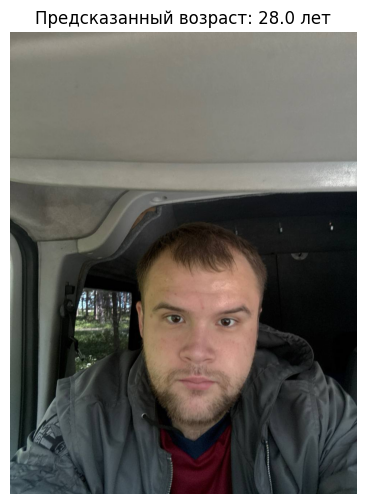

In [11]:
if __name__ == "__main__":
    # Изображение для предсказания
    test_img = '/content/drive/MyDrive/dataset/skufs/skuf2.jpg'

    # Результат предсказания
    result = predictor.predict_age_from_image(test_img)
    if result:
        # Вывод результатов предсказания
        img = cv2.imread(test_img)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(8, 6))
        plt.imshow(img_rgb)
        plt.title(f"Предсказанный возраст: {result} лет")
        plt.axis('off')
        plt.show()